# Build vocabulary

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

words=open('/kaggle/input/character-lm-without-framework/names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# Build dataset

In [2]:
# context length: how many characters do we take to predict the next one?
block_size=3
# X input of neural net, Y the lable of every element in X
X,Y=[],[]
for w in words: # first 5 words
    context=[0]*block_size # start with a padded context of zero tokens
    for ch in w+'.': # we always padding with .
        ix=stoi[ch]
        X.append(context)
        Y.append(ix)
        context=context[1:] +[ix] # crop and append
X=torch.tensor(X)
Y=torch.tensor(Y)

In [3]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

# Define the neural network

In [4]:
g=torch.Generator().manual_seed(2147483647)

C=torch.randn((27,2), generator=g)
W1=torch.randn((6, 100), generator=g)
b1=torch.randn(100, generator=g)
W2=torch.randn((100, 27), generator=g)
b2=torch.randn(27, generator=g)
parameters=[C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

3481


# Define the training loop

In [5]:
for p in parameters:
    p.requires_grad = True
    
for _ in range(100):
    # forward pass
    emb=C[X]
    h=torch.tanh(emb.view(-1, 6)@ W1+b1)
    logits=h @ W2+b2
    loss=F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    # update
    for p in parameters:
        p.data+=-0.1*p.grad
print(loss.item())

19.505226135253906
17.084484100341797
15.776531219482422
14.833340644836426
14.002608299255371
13.253263473510742
12.57991886138916
11.983102798461914
11.47049331665039
11.05185604095459
10.709587097167969
10.407631874084473
10.127808570861816
9.864364624023438
9.614501953125
9.376439094543457
9.148944854736328
8.931110382080078
8.722230911254883
8.521748542785645
8.32922649383545
8.144325256347656
7.966790676116943
7.796450614929199
7.633185386657715
7.476908206939697
7.327521800994873
7.184885025024414
7.048792362213135
6.9189534187316895
6.795018196105957
6.6766037940979
6.563319206237793
6.454790115356445
6.350668907165527
6.250643253326416
6.15443229675293
6.06178617477417
5.972482681274414
5.88632869720459
5.803147792816162
5.722784519195557
5.645095348358154
5.569947719573975
5.497213840484619
5.42678165435791
5.358536243438721
5.29237699508667
5.228204727172852
5.165929794311523
5.105469226837158
5.046748638153076
4.9897003173828125
4.934262275695801
4.880381107330322
4.8280072

# How we solve the issue of doing too much work forwarding and backwarding on too much examples? 

We should perform forward and backward pass and update on many batches of the data. We will want to do is we want to randomly select some portion of the dataset and that's a mini batch and then only forward backward and update on that little mini batch and then we iterate on those many batches. We can use `torch.randint()`

In [6]:
torch.randint(0,X.shape[0],(32,))

tensor([139897,  51240,    980, 157471,  14302,  66425, 116131,  95647, 135032,
        155388, 223767,  95620,  20472, 226271,  67450, 216576, 104914,  53464,
        189304, 101487, 175069,  26943,  44050, 147655,  55699,  14365,  61060,
        156035, 137394, 104787,  77714,  81815])

## Mini-batches

Because we're only dealing with mini batches the quality of our gradient is lower. So the directionis not as reliable. It's not the actual gradient direction, but the gradient direction is good enough even when it's estimating on only 32 examples.

It's much better to have an approximate gradient and just make more steps than it's to evalutate the exact gradeient and take fewer steps so that's why inpractice this works quite well.

In [7]:
g=torch.Generator().manual_seed(2147483647)

C=torch.randn((27,2), generator=g)
W1=torch.randn((6, 100), generator=g)
b1=torch.randn(100, generator=g)
W2=torch.randn((100, 27), generator=g)
b2=torch.randn(27, generator=g)
parameters=[C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

## Mini-baches
for _ in range(100):
    
    # minibatch construct
    ix=torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb=C[X[ix]]
    h=torch.tanh(emb.view(-1, 6)@ W1+b1)
    logits=h @ W2+b2
    loss=F.cross_entropy(logits, Y[ix])
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    # update
    for p in parameters:
        p.data+=-0.1*p.grad
print(loss.item())

3481
18.265348434448242
17.566810607910156
16.882610321044922
16.65780258178711
14.271449089050293
12.75853443145752
12.572443962097168
10.73294734954834
9.371048927307129
8.736696243286133
13.045344352722168
9.888445854187012
9.944649696350098
8.734502792358398
8.439384460449219
11.202192306518555
7.8204426765441895
9.332592964172363
8.097467422485352
8.653139114379883
9.526517868041992
9.59359073638916
10.225765228271484
8.52993106842041
8.270875930786133
8.031278610229492
8.235352516174316
7.350740909576416
8.371551513671875
7.4224066734313965
7.6326212882995605
6.658614158630371
6.815665245056152
7.720430374145508
6.630108833312988
6.699066162109375
7.461597919464111
7.716087818145752
6.700508117675781
5.870999336242676
7.715735912322998
5.543573379516602
5.4288330078125
4.942834854125977
5.097902297973633
5.076483726501465
3.918748617172241
6.507540702819824
4.416975975036621
3.9260783195495605
5.64549446105957
4.950249195098877
5.434813976287842
5.288244247436523
5.26093816757202

# Evaluate neural net on the whole dataset

In [8]:
g=torch.Generator().manual_seed(2147483647)

C=torch.randn((27,2), generator=g)
W1=torch.randn((6, 100), generator=g)
b1=torch.randn(100, generator=g)
W2=torch.randn((100, 27), generator=g)
b2=torch.randn(27, generator=g)
parameters=[C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


3481


# How we find a reasonable learning rate?

Currently, we set the learning rate randomly. Is there a better way to do this? We can use `tensor.linspace()` to define a range of the learning rate.

In [9]:
lre=torch.linspace(-3, 0, 1000)
lrs=10**lre

lri=[]
lossi=[]

for i in range(1000):
    
    # minibatch construct
    ix=torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb=C[X[ix]]
    h=torch.tanh(emb.view(-1, 6)@ W1+b1)
    logits=h @ W2+b2
    loss=F.cross_entropy(logits, Y[ix])
#     print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    # update
    lr=lrs[i]
    for p in parameters:
        p.data+=-lr*p.grad
        
    # track stats
    lri.append(lr)
    lossi.append(loss.item())
    
emb=C[X]
h=torch.tanh(emb.view(-1, 6) @ W1+b1) # (32, 100)
logits=h@W2+b2 #(32, 27)
loss=F.cross_entropy(logits, Y)
loss

tensor(6.0786, grad_fn=<NllLossBackward0>)

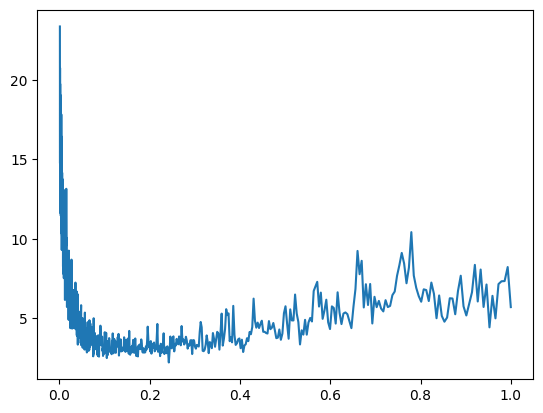

In [10]:
# x axis learning rate
# y axis is loss
plt.plot(lri, lossi)


# We can see the learning rate beteen 0.0-0.2 are what we want

# Explore the learning rate

In [11]:
g=torch.Generator().manual_seed(2147483647)

C=torch.randn((27,2), generator=g)
W1=torch.randn((6, 100), generator=g)
b1=torch.randn(100, generator=g)
W2=torch.randn((100, 27), generator=g)
b2=torch.randn(27, generator=g)
parameters=[C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True



lre=torch.linspace(-3, 0, 1000)
lrs=10**lre

lri=[]
lossi=[]

for i in range(1000):
    
    # minibatch construct
    ix=torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb=C[X[ix]]
    h=torch.tanh(emb.view(-1, 6)@ W1+b1)
    logits=h @ W2+b2
    loss=F.cross_entropy(logits, Y[ix])
#     print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    # update
    lr=lrs[i]
    for p in parameters:
        p.data+=-lr*p.grad
        
    # track stats
    lri.append(lre[i]) # we track the exponent
    lossi.append(loss.item())

# evaluate 
emb=C[X]
h=torch.tanh(emb.view(-1, 6) @ W1+b1) # (32, 100)
logits=h@W2+b2 #(32, 27)
loss=F.cross_entropy(logits, Y)
loss

3481


tensor(8.2339, grad_fn=<NllLossBackward0>)

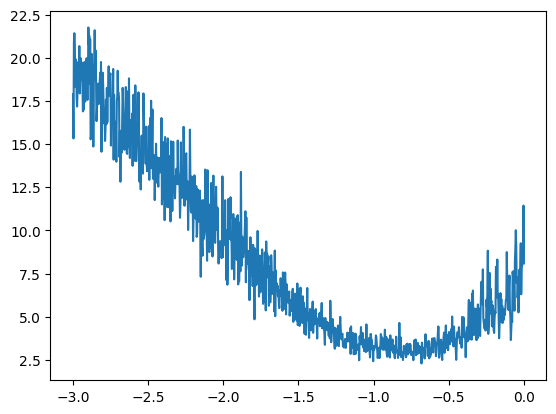

In [12]:
# x axis exponent of learning rate
# y axis is loss
plt.plot(lri, lossi)

# we can see that the learning rate of -1.0 is what we want to.

# We will use what we have found -1.0

In [13]:
g=torch.Generator().manual_seed(2147483647)

C=torch.randn((27,2), generator=g)
W1=torch.randn((6, 100), generator=g)
b1=torch.randn(100, generator=g)
W2=torch.randn((100, 27), generator=g)
b2=torch.randn(27, generator=g)
parameters=[C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

# embedding
emb=C[X]
h=torch.tanh(emb.view(-1, 6) @ W1+b1) # (32, 100)
logits=h@W2+b2 #(32, 27)
loss=F.cross_entropy(logits, Y)
loss

# define a range of learning rate
lre=torch.linspace(-3, 0, 1000)
lrs=10**lre

lri=[]
lossi=[]

for i in range(1000):
    
    # minibatch construct
    ix=torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb=C[X[ix]]
    h=torch.tanh(emb.view(-1, 6)@ W1+b1)
    logits=h @ W2+b2
    loss=F.cross_entropy(logits, Y[ix])
#     print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    # update
    lr=0.1
    for p in parameters:
        p.data+=-lr*p.grad
        
    # track stats
#     lri.append(lre[i]) # we track the exponent
#     lossi.append(loss.item())

3481


In [14]:
# evaluate 
emb=C[X]
h=torch.tanh(emb.view(-1, 6) @ W1+b1) # (32, 100)
logits=h@W2+b2 #(32, 27)
loss=F.cross_entropy(logits, Y)
loss

tensor(2.6806, grad_fn=<NllLossBackward0>)

# Decay the loss

After we train for a while and then, we will do the learning rate decay.

From loss=2.68, we decrease loss from 0.1 -> 0.01 and do the training again. We can get more lower loss.

In [15]:
for i in range(1000):
    
    # minibatch construct
    ix=torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb=C[X[ix]]
    h=torch.tanh(emb.view(-1, 6)@ W1+b1)
    logits=h @ W2+b2
    loss=F.cross_entropy(logits, Y[ix])
#     print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    # update
    lr=0.01
    for p in parameters:
        p.data+=-lr*p.grad

emb=C[X]
h=torch.tanh(emb.view(-1, 6) @ W1+b1) # (32, 100)
logits=h@W2+b2 #(32, 27)
loss=F.cross_entropy(logits, Y)
loss

tensor(2.5909, grad_fn=<NllLossBackward0>)

# Acknowledgement

* https://www.youtube.com/watch?v=TCH_1BHY58I&t=1758s
* https://www.kaggle.com/code/aisuko/multilayer-perceptron-implement
* https://www.kaggle.com/code/aisuko/character-lm-without-framework